Welcome to Voxelmap!

The first thing we'll do is train the neural network (Network A). We'll then test the network to see how it performs. After you've installed all the dependencies in the setup.cfg file, let's do some imports to get started.

In [35]:
# imports
import time
import os
import numpy as np
from matplotlib import pyplot as plt
from utilities import network_a, losses
import torch
from torch.utils.data import Dataset
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

We recommend installing the example data at https://ses.library.usyd.edu.au/handle/2123/32282 and adding the unzipped 'data' folder to your present working directory. We'll then define our image directory as 'data/xcat/train' and define a filename to save our weights and loss plots.

In [36]:
# file name and image directory
im_dir = 'data/xcat/train'
expt_description = 'Network A'
filename = 'train_a'

Next we'll create a class called 'SupervisedDataset'. This will allow us to load the appropriate data onto the neural network for training. There are a few idiosyncrasies that we may wish to note. First, all the projection data ends in 'bin.npy' because they were originally created as binary files but were converted to .npy files for convience. The same goes for the volumes and DVFs, which end in 'mha.npy' for similar reasons. The source projection has a '06' in front because, in 4D-CTs the 6 respiratory bin corresponds with the peak-exhale phase. We name our projections 'phase_Proj_num', where phase is respiratory phase (i.e. '01', '02', ... '10') and num is the projection number (e.g. '00001'). For Networks D and E, where we train on the CoMBAT MRI data, the naming convention for slice pairs is 'phase_Slice_xc_ys' where x is the slice number along the coronal axis and y is the slice number along the sagittal axis.

An abdominal mask is used later on in the loss function to force the neural network to optimise predictions within a specific region. The data are then reshaped for the specific dimensions expected for a PyTorch neural network. Right now we are also limited to image sizes that are powers of two (e.g. projections 128x128 and volumes 128x128x128). Everything has been downsampled here to fit on the GPU.

In [37]:
# set up training dataset class
class SupervisedDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None):
        self.im_dir = im_dir
        self.im_size = im_size

    def __len__(self):
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])

    def __getitem__(self, idx):
        # Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])
        target_file = proj_list[idx]
        proj_name = os.path.join(self.im_dir, format(target_file))
        target_proj = np.load(proj_name)
        target_proj = (target_proj - np.min(target_proj)) / (np.max(target_proj) - np.min(target_proj))

        # Find target DVF
        vol_num = target_file[:2]
        dvf_name = os.path.join(self.im_dir, format('sub_DVF_' + vol_num + '_mha.npy'))
        target_dvf = np.load(dvf_name)

        # Find source projection
        source_file = '06_' + target_file[3:]
        proj_name = os.path.join(self.im_dir, format(source_file))
        source_proj = np.load(proj_name)
        source_proj = (source_proj - np.min(source_proj)) / (np.max(source_proj) - np.min(source_proj))

        # Find source volume
        vol_name = os.path.join(self.im_dir, format('sub_CT_06_mha.npy'))
        source_vol = np.load(vol_name)
        source_vol = (source_vol - np.min(source_vol)) / (np.max(source_vol) - np.min(source_vol))

        # Find source abdomen
        vol_name = os.path.join(self.im_dir, format('sub_Abdomen_mha.npy'))
        source_hull = np.load(vol_name)

        # Reshape data
        source_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        source_projections[0, :, :] = np.asarray(source_proj)
        target_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        target_projections[0, :, :] = np.asarray(target_proj)

        source_volumes = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_volumes[0, :, :, :] = np.asarray(source_vol)
        source_abdomen = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_abdomen[0, :, :, :] = np.asarray(source_hull)

        target_flow = np.zeros((3, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        target_flow[0, :, :, :] = target_dvf[:, :, :, 0]
        target_flow[1, :, :, :] = target_dvf[:, :, :, 1]
        target_flow[2, :, :, :] = target_dvf[:, :, :, 2]

        data = {'source_projections': torch.from_numpy(source_projections),
                'target_projections': torch.from_numpy(target_projections),
                'source_volumes': torch.from_numpy(source_volumes),
                'source_abdomen': torch.from_numpy(source_abdomen),
                'target_flow': torch.from_numpy(target_flow)}
        
        return data

Let's visualise a projection, a volume and a DVF to make sure our dataloader is working properly.

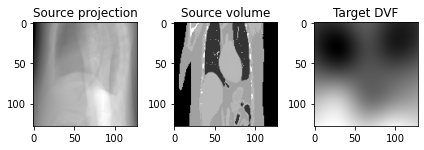

In [38]:
# Generate test loader
batch_size = 1
im_size = 128
exampleset = SupervisedDataset(im_dir=im_dir, im_size=im_size)
exampleloader = torch.utils.data.DataLoader(exampleset, batch_size=batch_size)
data = next(iter(exampleloader))

source_proj, target_proj, source_vol, source_abdomen, target_flow = data['source_projections'], \
                                                                                        data['target_projections'], \
                                                                                        data['source_volumes'], \
                                                                                        data['source_abdomen'], \
                                                                                        data['target_flow']
# visualise projection, volume and DVF
f = plt.figure()
plt.subplot(1,3,1)
source_proj = np.squeeze(source_proj)
plt.imshow(source_proj, cmap='gray')
plt.title('Source projection')

plt.subplot(1,3,2)
source_vol = np.squeeze(source_vol)
plt.imshow(np.transpose(source_vol[:,:, int(source_vol.shape[2] / 2)]), cmap='gray')
plt.title('Source volume')

plt.subplot(1,3,3)
target_flow = np.squeeze(target_flow)
plt.imshow(np.flipud(np.transpose(target_flow[1,:,:, int(source_vol.shape[2] / 2)])), cmap='gray')
plt.title('Target DVF')

f.tight_layout()
plt.show()

Lookin' good! Now we will create training and validation datasets

In [39]:
# generate train/test split
im_size = 128
batch_size = 8
dataset = SupervisedDataset(im_dir=im_dir, im_size=im_size)
split = [int(len(dataset) * 0.9), int(len(dataset) * 0.1)]
trainset, valset = torch.utils.data.dataset.random_split(dataset, split)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

Network time! Let's set up a cuda implementation of the network, a loss function (good ol' MSE will do! but we're computing it within a thoracoabdominal mask) and an optimizer

In [42]:
# set up network
model = network_a.model(im_size, int_steps=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# set loss function and optimizer
flow_mask = losses.flow_mask()
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)

AttributeError: module 'utilities.network_a' has no attribute 'model'

Are you ready? Next thing to do is to train the network :) We'll save the weights and a plot of the loss curves. We recommend training for 50 epochs. (Using a NVIDIA RTX A6000, this will take about 6 hours, so we may need to come back tomorrow.)

Training (on cuda:0)...
Epoch: 1 | train loss: 0.0942 | val loss: 0.0281 | total time: 0 hours 7 minutes
Epoch: 2 | train loss: 0.0426 | val loss: 0.0138 | total time: 0 hours 15 minutes
Epoch: 3 | train loss: 0.0270 | val loss: 0.0501 | total time: 0 hours 23 minutes
Epoch: 4 | train loss: 0.0185 | val loss: 0.0180 | total time: 0 hours 31 minutes
Epoch: 5 | train loss: 0.0135 | val loss: 0.0051 | total time: 0 hours 38 minutes
Epoch: 6 | train loss: 0.0101 | val loss: 0.0125 | total time: 0 hours 46 minutes
Epoch: 7 | train loss: 0.0080 | val loss: 0.0103 | total time: 0 hours 54 minutes
Epoch: 8 | train loss: 0.0067 | val loss: 0.0015 | total time: 1 hours 2 minutes
Epoch: 9 | train loss: 0.0056 | val loss: 0.0069 | total time: 1 hours 10 minutes
Epoch: 10 | train loss: 0.0048 | val loss: 0.0082 | total time: 1 hours 18 minutes
Epoch: 11 | train loss: 0.0036 | val loss: 0.0042 | total time: 1 hours 26 minutes
Epoch: 12 | train loss: 0.0028 | val loss: 0.0016 | total time: 1 hours 33

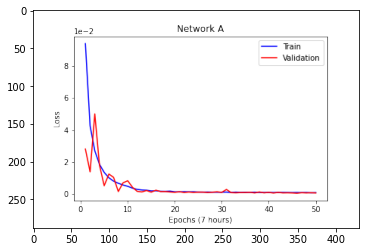

In [41]:
# train
print('Training (on ' + str(device) + ')...')
tic = time.time()
min_val_loss = float('inf')
train_losses, val_losses = [], []
epoch_num = 50

for epoch in range(1, epoch_num + 1):
    train_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        source_proj, target_proj, source_vol, source_abdomen, target_flow = data['source_projections'].to(device), \
                                                                            data['target_projections'].to(device), \
                                                                            data['source_volumes'].to(device), \
                                                                            data['source_abdomen'].to(device), \
                                                                            data['target_flow'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        _, predict_flow = model.forward(source_proj, target_proj, source_vol)
        loss = flow_mask.loss(target_flow, predict_flow, source_abdomen)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # test and print every epoch
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for j, valdata in enumerate(valloader, 0):
            source_proj, target_proj, source_vol, source_abdomen, target_flow = data['source_projections'].to(device), \
                                                                                data['target_projections'].to(device), \
                                                                                data['source_volumes'].to(device), \
                                                                                data['source_abdomen'].to(device), \
                                                                                data['target_flow'].to(device)

            _, predict_flow = model.forward(source_proj, target_proj, source_vol)
            loss = flow_mask.loss(target_flow, predict_flow, source_abdomen)
            val_loss += loss.item()

    toc = time.time()
    time_elapsed = (toc - tic) / 3600
    hours = np.floor(time_elapsed)
    minutes = (time_elapsed - hours) * 60

    print('Epoch: %d | train loss: %.4f | val loss: %.4f | total time: %d hours %d minutes' %
          (epoch, train_loss / len(trainset), val_loss / len(valset), hours, minutes))
    train_losses.append(train_loss / len(trainset))
    val_losses.append(val_loss / len(valset))

    # save model with lowest validation cost
    if val_loss < min_val_loss:
        if not os.path.exists('weights'):
            os.mkdir('weights')
        PATH = 'weights/' + filename + '.pth'
        torch.save(model.state_dict(), PATH)
        min_val_loss = val_loss

    # plot training
    plt.figure()
    plt.title(expt_description)
    plt.plot(np.array(range(1, epoch + 1)), np.array(train_losses), 'b')
    plt.plot(np.array(range(1, epoch + 1)), np.array(val_losses), 'r')
    plt.legend(['Train', 'Validation'])
    plt.ylabel('Loss')
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    if minutes > 30:
        hours += 1
    plt.xlabel('Epochs' + ' (' + str(int(hours)) + ' hours)')
    if not os.path.exists('plots'):
        os.mkdir('plots')
    plt.savefig('plots/' + filename + '.png')
    plt.close()

print('Finished training')
torch.cuda.empty_cache()

plt.imshow(plt.imread('plots/' + filename + '.png'))
plt.show()

That was an exciting moment...we now have a trained neural network. Last thing to do is test it! First, let's point to the weights we want and the directory for our unseen test data.

In [43]:
# file names
expt_file = 'train_a'
test_file = 'data/xcat/test'

Just as we did for training, we will create a new class that allows us to load our test data. This class looks a lot more involved because we have lots and lots of things to test: target overlap, OAR overlap, image similarity...

In [44]:
# set up validation dataset class
class validateXCATDataset(Dataset):

    def __init__(self, im_dir=None, ref_dir=None, im_size=None):
        self.im_dir = im_dir
        self.ref_dir = ref_dir
        self.im_size = im_size

    def __len__(self):
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])

    def __getitem__(self, idx):
        # Find target angle
        angle = os.path.join(self.im_dir, format('Angles.csv'))
        angle = np.genfromtxt(angle)
        angle = angle[idx]

        # Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])
        target_file = proj_list[idx]
        proj_name = os.path.join(self.im_dir, format(target_file))
        target_proj = np.load(proj_name)

        # Find source projection
        proj_name = os.path.join(self.ref_dir, format('06_' + target_file))
        source_proj = np.load(proj_name)

        # Find source volume
        vol_name = os.path.join(self.ref_dir, format('sub_CT_06_mha.npy'))
        source_vol = np.load(vol_name)

        # Find source contours
        vol_name = os.path.join(self.ref_dir, format('Source_mha.npy'))
        source_ptv = np.load(vol_name)

        vol_name = os.path.join(self.ref_dir, format('Eso_source_mha.npy'))
        source_eso = np.load(vol_name)

        vol_name = os.path.join(self.ref_dir, format('Sto_source_mha.npy'))
        source_sto = np.load(vol_name)

        vol_name = os.path.join(self.ref_dir, format('LungL_source_mha.npy'))
        source_lungL = np.load(vol_name)

        vol_name = os.path.join(self.ref_dir, format('LungR_source_mha.npy'))
        source_lungR = np.load(vol_name)

        vol_name = os.path.join(self.ref_dir, format('SpCord_source_mha.npy'))
        source_spcord = np.load(vol_name)

        # Find target volume
        vol_list = sorted([n for n in os.listdir(self.im_dir) if n.startswith('Vol') & n.endswith('_mha.npy')])
        target_file = vol_list[idx]
        vol_name = os.path.join(self.im_dir, format(target_file))
        target_vol = np.load(vol_name)

        # Find target contours
        target_num = target_file.split('_')
        target_num = target_num[1]

        vol_name = os.path.join(self.im_dir, format('Target_' + target_num + '_mha.npy'))
        target_ptv = np.load(vol_name)

        vol_name = os.path.join(self.im_dir, format('Eso_' + target_num + '_mha.npy'))
        target_eso = np.load(vol_name)

        vol_name = os.path.join(self.im_dir, format('Sto_' + target_num + '_mha.npy'))
        target_sto = np.load(vol_name)

        vol_name = os.path.join(self.im_dir, format('LungL_' + target_num + '_mha.npy'))
        target_lungL = np.load(vol_name)

        vol_name = os.path.join(self.im_dir, format('LungR_' + target_num + '_mha.npy'))
        target_lungR = np.load(vol_name)

        vol_name = os.path.join(self.im_dir, format('SpCord_' + target_num + '_mha.npy'))
        target_spcord = np.load(vol_name)

        # Reshape data to correct format
        source_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        source_projections[0, :, :] = np.asarray(source_proj)

        target_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        target_projections[0, :, :] = np.asarray(target_proj)

        source_volumes = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_volumes[0, :, :, :] = np.asarray(source_vol)

        source_ptvs = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_ptvs[0, :, :, :] = np.asarray(source_ptv)

        source_esophagus = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_esophagus[0, :, :, :] = np.asarray(source_eso)

        source_stomach = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_stomach[0, :, :, :] = np.asarray(source_sto)

        source_lungsR = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_lungsR[0, :, :, :] = np.asarray(source_lungR)

        source_lungsL = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_lungsL[0, :, :, :] = np.asarray(source_lungL)

        source_spinalcord = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_spinalcord[0, :, :, :] = np.asarray(source_spcord)

        target_volumes = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        target_volumes[0, :, :, :] = np.asarray(target_vol)

        target_ptvs = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        target_ptvs[0, :, :, :] = np.asarray(target_ptv)

        target_esophagus = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        target_esophagus[0, :, :, :] = np.asarray(target_eso)

        target_stomach = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        target_stomach[0, :, :, :] = np.asarray(target_sto)

        target_lungsL = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        target_lungsL[0, :, :, :] = np.asarray(target_lungL)

        target_lungsR = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        target_lungsR[0, :, :, :] = np.asarray(target_lungR)

        target_spinalcord = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        target_spinalcord[0, :, :, :] = np.asarray(target_spcord)

        data = {'source_projections': torch.from_numpy(source_projections),
                'target_projections': torch.from_numpy(target_projections),
                'source_volumes': torch.from_numpy(source_volumes),
                'source_ptvs': torch.from_numpy(source_ptvs),
                'source_esophagus': torch.from_numpy(source_esophagus),
                'source_stomach': torch.from_numpy(source_stomach),
                'source_lungsL': torch.from_numpy(source_lungsL),
                'source_lungsR': torch.from_numpy(source_lungsR),
                'source_spinalcord': torch.from_numpy(source_spinalcord),
                'target_volumes': torch.from_numpy(target_volumes),
                'target_ptvs': torch.from_numpy(target_ptvs),
                'target_esophagus': torch.from_numpy(target_esophagus),
                'target_stomach': torch.from_numpy(target_stomach),
                'target_lungsL': torch.from_numpy(target_lungsL),
                'target_lungsR': torch.from_numpy(target_lungsR),
                'target_spinalcord': torch.from_numpy(target_spinalcord),
                'angle': angle
                }
        
        return data

Let's instantiate the validation dataset class, set up a cuda implementation, and load the pre-trained weights of our network. We'll also print the number of trainable parameters for our records.

In [45]:
# Generate test loader
batch_size = 1
im_size = 128
dataset = validateXCATDataset(im_dir=test_file, ref_dir=test_file + '/source', im_size=im_size)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Import network and set up cuda implementation
model = network_a.VxmDense(im_size, int_steps=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load weights
PATH = 'weights/' + expt_file + '.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

print('Number of paramters: %d' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))

Number of paramters: 10836973


Next we'll load a spatial transformation module. This will allow us to take in a predicted DVF and use it to warp reference images and volumes.

In [46]:
# Load transformer
from utilities import spatialTransform
transformer = spatialTransform.Network([im_size, im_size, im_size])
transformer.to(device)

Network(
  (transformer): SpatialTransformer()
)

Let's load up some loss functions. Here we'll look at the difference in centroid positions, Dice similarity to the target and OAR contours, the Jacobian determinant of predicted DVFs as well as the structural similarity and peak signal-to-noise ratio of the predicted images (courtesy of the skimage.metrics library). We'll also create some empty lists to save these metrics

In [47]:
# loss functions
centroid_ptv = losses.centroid_ptv()
dice = losses.dice()
jacobian_determinant = losses.jacobian_determinant()
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# initialise target tracking metrics
tar_lr, tar_si, tar_ap, pred_lr, pred_si, pred_ap, test_dice, test_detJ, test_angles = [], [], [], [], [], [], [], [], []

# initialise OAR tracking metrics
stomach_dice, esophagus_dice, lungL_dice, lungR_dice, spinalcord_dice, = [], [], [], [], []

# initialise image metrics
test_mse, test_ssim, test_psnr = [], [], []

Ok, let's iterate over our unseen test data, recording all the metrics we want. (It may take a couple of minutes to run through all our examples)

In [48]:
print('Testing...')
for i, data in enumerate(testloader, 0):
    (source_proj, target_proj, source_vol, source_ptv, source_eso, source_sto, source_lungL, source_lungR,
        source_spcord,target_vol, target_ptv, target_eso, target_sto, target_lungL, target_lungR, target_spcord, angle) = data[
        'source_projections'].to(device), \
        data['target_projections'].to(device), \
        data['source_volumes'].to(device), \
        data['source_ptvs'].to(device), \
        data['source_esophagus'].to(device), \
        data['source_stomach'].to(device), \
        data['source_lungsL'].to(device), \
        data['source_lungsR'].to(device), \
        data['source_spinalcord'].to(device), \
        data['target_volumes'].to(device), \
        data['target_ptvs'].to(device), \
        data['target_esophagus'].to(device), \
        data['target_stomach'].to(device), \
        data['target_lungsL'].to(device), \
        data['target_lungsR'].to(device), \
        data['target_spinalcord'].to(device), \
        data['angle'].to(device)

    predict_ptv, predict_flow = model.forward(source_proj, target_proj, source_ptv)

    lr, si, ap = centroid_ptv.loss(target_ptv)

    # convert to mm (to account for subsampling)
    lr = 4 * lr
    si = 2 * si
    ap = 4 * ap

    tar_lr.append(lr)
    tar_si.append(si)
    tar_ap.append(ap)

    lr, si, ap = centroid_ptv.loss(predict_ptv)

    # convert to mm (to account for subsampling)
    lr = 4 * lr
    si = 2 * si
    ap = 4 * ap

    pred_lr.append(lr)
    pred_si.append(si)
    pred_ap.append(ap)

    # compute and save dice similarity
    dice_sim = dice.loss(target_ptv, predict_ptv)
    test_dice.append(dice_sim.item())

    # compute and save Jacobian violation ratio
    disp = np.zeros((im_size, im_size, im_size, 3), dtype=np.float32)
    metric_flows = np.squeeze(predict_flow.detach().cpu().numpy())
    disp[:, :, :, 0] = metric_flows[0, :, :, :]
    disp[:, :, :, 1] = metric_flows[1, :, :, :]
    disp[:, :, :, 2] = metric_flows[2, :, :, :]
    detJ = jacobian_determinant.loss(disp)
    detJ = sum(i <= 0 for i in detJ.flatten()) / detJ.size
    test_detJ.append(detJ.item())

    # save gantry angle
    test_angles.append(angle.item())

    # warp images
    predict_vol = transformer.forward(source_vol, predict_flow)

    # detach images from GPU
    metric_input = target_vol.cpu().detach().numpy()
    metric_input = metric_input.flatten()
    metric_pred = predict_vol.cpu().detach().numpy()
    metric_pred = metric_pred.flatten()

    mse_loss = np.sqrt(np.mean(np.square((metric_input.ravel() - metric_pred.ravel()))))
    ssim_loss = ssim(metric_input, metric_pred, data_range=np.max(metric_pred) - np.min(metric_pred))
    psnr_loss = psnr(metric_input, metric_pred)

    test_mse.append(mse_loss)
    test_ssim.append(ssim_loss)
    test_psnr.append(psnr_loss)

    # stomach
    predict_sto = transformer.forward(source_sto, predict_flow)
    dice_sim = dice.loss(target_sto, predict_sto)
    stomach_dice.append(dice_sim.item())

    # esophagus
    predict_eso = transformer.forward(source_eso, predict_flow)
    dice_sim = dice.loss(target_eso, predict_eso)
    esophagus_dice.append(dice_sim.item())

    # lungL
    predict_lungL = transformer.forward(source_lungL, predict_flow)
    dice_sim = dice.loss(target_lungL, predict_lungL)
    lungL_dice.append(dice_sim.item())

    # lungR
    predict_lungR = transformer.forward(source_lungR, predict_flow)
    dice_sim = dice.loss(target_lungR, predict_lungR)
    lungR_dice.append(dice_sim.item())

    # spinal cord
    predict_spcord = transformer.forward(source_spcord, predict_flow)
    dice_sim = dice.loss(target_spcord, predict_spcord)
    spinalcord_dice.append(dice_sim.item())

    if i % 10 == 0:
        print(str(i) + ' of ' + str(len(testloader)))

Testing...
0 of 630
10 of 630
20 of 630
30 of 630
40 of 630
50 of 630
60 of 630
70 of 630
80 of 630
90 of 630
100 of 630
110 of 630
120 of 630
130 of 630
140 of 630
150 of 630
160 of 630
170 of 630
180 of 630
190 of 630
200 of 630
210 of 630
220 of 630
230 of 630
240 of 630
250 of 630
260 of 630
270 of 630
280 of 630
290 of 630
300 of 630
310 of 630
320 of 630
330 of 630
340 of 630
350 of 630
360 of 630
370 of 630
380 of 630
390 of 630
400 of 630
410 of 630
420 of 630
430 of 630
440 of 630
450 of 630
460 of 630
470 of 630
480 of 630
490 of 630
500 of 630
510 of 630
520 of 630
530 of 630
540 of 630
550 of 630
560 of 630
570 of 630
580 of 630
590 of 630
600 of 630
610 of 630
620 of 630


Let's save the results in a directory called 'plots'

In [51]:
if not os.path.exists('plots/' + expt_file):
    os.mkdir('plots/' + expt_file)

# save target metrics
np.save('plots/' + expt_file + '/' + 'test_angles', test_angles)
np.save('plots/' + expt_file + '/' + 'tar_lr (mm)', tar_lr)
np.save('plots/' + expt_file + '/' + 'tar_si (mm)', tar_si)
np.save('plots/' + expt_file + '/' + 'tar_ap (mm)', tar_ap)
np.save('plots/' + expt_file + '/' + 'pred_lr (mm)', pred_lr)
np.save('plots/' + expt_file + '/' + 'pred_si (mm)', pred_si)
np.save('plots/' + expt_file + '/' + 'pred_ap (mm)', pred_ap)
np.save('plots/' + expt_file + '/' + 'test_dice', test_dice)
np.save('plots/' + expt_file + '/' + 'test_detJ', test_detJ)

# save OAR metrics
np.save('plots/' + expt_file + '/' + 'stomach_dice', stomach_dice)
np.save('plots/' + expt_file + '/' + 'esophagus_dice', esophagus_dice)
np.save('plots/' + expt_file + '/' + 'lungL_dice', lungL_dice)
np.save('plots/' + expt_file + '/' + 'lungR_dice', lungR_dice)
np.save('plots/' + expt_file + '/' + 'spinalcord_dice', spinalcord_dice)

# save image metrics
np.save('plots/' + expt_file + '/' + 'test_ssim', test_ssim)
np.save('plots/' + expt_file + '/' + 'test_psnr', test_psnr)

Lastly, we'll print the results and generate a tracking plot for the centroid positions, et voila! I hope you enjoy using Voxelmap. We have started a Discussion section on the Github repository to hear about your experiences.

[PTV Dice: 0.82 ± 0.07 | 3D : 3.7 ± 1.2 | detJ: 0E+00]
[Target DSC: 0.82 ± 0.07 | Stomach DSC: 0.81 ± 0.07 | Esophagus DSC: 0.80 ± 0.06 | Lung L DSC: 0.94 ± 0.02 | Lung R DSC: 0.93 ± 0.02 | Spinal cord DSC: 0.94 ± 0.01]
[SSIM: 0.94 ± 0.01 | PSNR: 59.4 ± 1.0]


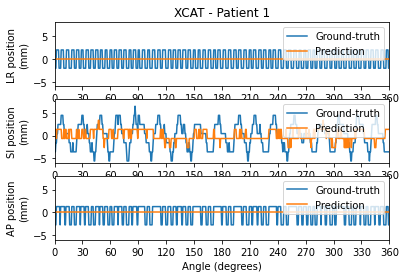

In [53]:
# print results
dx = np.asarray(tar_lr) - np.asarray(pred_lr)
dy = np.asarray(tar_si) - np.asarray(pred_si)
dz = np.asarray(tar_ap) - np.asarray(pred_ap)

print('[PTV Dice: %.2f ± %.2f' % (np.mean(test_dice), np.std(test_dice)) +
    ' | 3D : %.1f ± %.1f' % (np.mean(np.sqrt(dx**2 + dy**2 + dz**2)), np.std(np.sqrt(dx**2 + dy**2 + dz**2))) +
    ' | detJ: %.0E' % (np.mean(test_detJ)) + ']')

print('[Target DSC: %.2f ± %.2f' % (np.mean(test_dice), np.std(test_dice)) +
    ' | Stomach DSC: %.2f ± %.2f' % (np.mean(stomach_dice), np.std(stomach_dice)) +
    ' | Esophagus DSC: %.2f ± %.2f' % (np.mean(esophagus_dice), np.std(esophagus_dice)) +
    ' | Lung L DSC: %.2f ± %.2f' % (np.mean(lungL_dice), np.std(lungL_dice)) +
    ' | Lung R DSC: %.2f ± %.2f' % (np.mean(lungR_dice), np.std(lungR_dice)) +
    ' | Spinal cord DSC: %.2f ± %.2f' % (np.mean(spinalcord_dice), np.std(spinalcord_dice)) + ']')

print('[SSIM: %.2f ± %.2f' % (np.mean(test_ssim), np.std(test_ssim)) +
    ' | PSNR: %.1f ± %.1f' % (np.mean(test_psnr), np.std(test_psnr)) +']')

# plot centroid traces
tar_lr = tar_lr - np.mean(tar_lr)
tar_lr = [tar_lr for _, tar_lr in sorted(zip(test_angles, tar_lr))]
tar_si = tar_si - np.mean(tar_si)
tar_si = [tar_si for _, tar_si in sorted(zip(test_angles, tar_si))]
tar_ap = tar_ap - np.mean(tar_ap)
tar_ap = [tar_ap for _, tar_ap in sorted(zip(test_angles, tar_ap))]

pred_lr = pred_lr - np.mean(pred_lr)
pred_lr = [pred_lr for _, pred_lr in sorted(zip(test_angles, pred_lr))]
pred_si = pred_si - np.mean(pred_si)
pred_si = [pred_si for _, pred_si in sorted(zip(test_angles, pred_si))]
pred_ap = pred_ap - np.mean(pred_ap)
pred_ap = [pred_ap for _, pred_ap in sorted(zip(test_angles, pred_ap))]

test_angles = sorted(test_angles)

f = plt.figure()
f.add_subplot(3, 1, 1)
plt.plot(test_angles, tar_lr)
plt.plot(test_angles, pred_lr)
plt.xlabel('Angle (degrees)')
plt.ylabel('LR position\n(mm)')
plt.title('XCAT - Patient 1')
plt.legend(['Ground-truth', 'Prediction'], loc='upper right')
plt.ylim([-6, 8])
plt.xlim([0, 360])
plt.xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360])

f.add_subplot(3, 1, 2)
plt.plot(test_angles, tar_si)
plt.plot(test_angles, pred_si)
plt.xlabel('Angle (degrees)')
plt.ylabel('SI position\n(mm)')
plt.legend(['Ground-truth', 'Prediction'], loc='upper right')
plt.ylim([-6, 8])
plt.xlim([0, 360])
plt.xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360])

f.add_subplot(3, 1, 3)
plt.plot(test_angles, tar_ap)
plt.plot(test_angles, pred_ap)
plt.xlabel('Angle (degrees)')
plt.ylabel('AP position\n(mm)')
plt.legend(['Ground-truth', 'Prediction'], loc='upper right')
plt.ylim([-6, 8])
plt.xlim([0, 360])
plt.xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360])

plt.savefig('plots/' + expt_file + '_trace.png')
plt.show()